<a href="https://colab.research.google.com/github/racoope70/BERTified/blob/main/Results_Rebalance_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%
# Import necessary libraries
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, get_scheduler
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from google.colab import drive
import tensorflow as tf
from sklearn.metrics import accuracy_score
import gc  # Import garbage collection for memory management
from huggingface_hub import notebook_login
from collections import Counter


In [2]:
# %%
# Step 1: Install required libraries (run this only once to install dependencies)
!pip install transformers pandas scikit-learn torch torchvision torchaudio matplotlib seaborn


In [68]:
# Step 2: Load IMDb Dataset
def load_imdb_dataset(base_path):
    """
    Loads the IMDb dataset from given directory structure and returns a DataFrame with reviews and sentiments.
    """
    reviews = []
    sentiments = []

    # Iterate over both train and test data
    for split in ['train', 'test']:
        for sentiment in ['pos', 'neg']:
            path = os.path.join(base_path, split, sentiment)
            # Read reviews from each file
            for file_name in os.listdir(path):
                with open(os.path.join(path, file_name), 'r', encoding='utf-8') as file:
                    reviews.append(file.read())
                    sentiments.append(1 if sentiment == 'pos' else 0)

    return pd.DataFrame({'review': reviews, 'sentiment': sentiments})

In [4]:
# Step 3: Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
# Step 4: Define paths for saving datasets and results
base_path = '/content/drive/MyDrive/aclImdb'
csv_file_path = '/content/drive/MyDrive/aclImdb_reviews.csv'
results_dir = '/content/drive/MyDrive/sentiment_analysis_results'  # Define the directory for saving results

# Ensure the results directory exists
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

if os.path.exists(csv_file_path):
    df = pd.read_csv(csv_file_path)
else:
    df = load_imdb_dataset(base_path)
    df.to_csv(csv_file_path, index=False)


In [70]:
# Step 5: Sample a subset of the data
data = df.sample(10000)


In [71]:
# Step 6: Split the data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['review'], data['sentiment'], test_size=0.2, random_state=42
)

# Free up memory after splitting
del df, data
gc.collect()

7

In [8]:
# Step 7: Authenticate with Hugging Face Hub (Optional)
# This allows for better access and avoids rate limits when downloading public models/datasets
#notebook_login()


In [72]:
# Step 8: Tokenize Text using BERT Tokenizer in Batches
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(texts, tokenizer, batch_size=64):
    """
    Tokenizes input texts in smaller batches to optimize memory usage.
    """
    tokenized_data = {"input_ids": [], "attention_mask": []}
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size].tolist()
        encodings = tokenizer(batch, truncation=True, padding=True, max_length=256)
        tokenized_data["input_ids"].extend(encodings["input_ids"])
        tokenized_data["attention_mask"].extend(encodings["attention_mask"])
    return tokenized_data

# Tokenize training and testing data
train_encodings = tokenize_data(train_texts, tokenizer)
test_encodings = tokenize_data(test_texts, tokenizer)

train_texts_list = train_texts.tolist()  # Convert training texts to a list
train_labels_list = train_labels.tolist()  # Convert training labels to a list



In [73]:
# Step 9: Define Dataset Class
class SentimentDataset(torch.utils.data.Dataset):
    """
    Custom Dataset class for sentiment analysis.
    """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Rebalance the training dataset
from imblearn.over_sampling import RandomOverSampler

# Convert training texts and labels to a compatible format
train_texts_list = train_texts.tolist()  # Ensure train_texts is a list
train_labels_list = train_labels.tolist()

# Perform oversampling
ros = RandomOverSampler(random_state=42)
train_texts_resampled, train_labels_resampled = ros.fit_resample(
    pd.DataFrame({'text': train_texts_list}),  # Use a DataFrame to keep structure
    train_labels_list
)

# Tokenize the resampled training data
train_encodings_resampled = tokenizer(
    train_texts_resampled['text'].tolist(), truncation=True, padding=True, max_length=128
)

# Prepare rebalanced training dataset
train_dataset = SentimentDataset(train_encodings_resampled, list(train_labels_resampled))

# Prepare testing dataset (unchanged)
test_dataset = SentimentDataset(test_encodings, list(test_labels))

# Free memory after creating datasets
del train_encodings, test_encodings, train_labels, test_labels
gc.collect()


0

In [75]:
# %%
# Step 10: Set up the model with BERT and GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
# Step 11: Define Training Arguments with Checkpoints
training_args = TrainingArguments(
    output_dir=results_dir,  # Save checkpoints to Google Drive
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,  # Limit the number of saved checkpoints
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.1,
    logging_dir=os.path.join(results_dir, "logs"),  # Log directory
    fp16=True,  # Mixed precision training
    load_best_model_at_end=True,  # Load the best model
    report_to="tensorboard",
)

In [77]:
# %%
# Step 12: Train Model with Checkpoints
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_dataset)
)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, lr_scheduler),
)

# Free memory before training
gc.collect()


75

In [78]:
# %%
# Step 12: Start the training process
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.235711
2,No log,0.257186
3,No log,0.343364


TrainOutput(global_step=438, training_loss=0.9586595509150256, metrics={'train_runtime': 244.6739, 'train_samples_per_second': 114.544, 'train_steps_per_second': 1.79, 'total_flos': 1843487609379840.0, 'train_loss': 0.9586595509150256, 'epoch': 3.0})

In [79]:
# %%
# Step 13: Evaluate the model's performance
# Ensure that test labels and predictions are on the same device
preds = trainer.predict(test_dataset).predictions


# Calculate accuracy
test_labels_tensor = torch.tensor(list(test_dataset.labels)).to(torch.device("cpu"))
binary_preds = torch.argmax(torch.tensor(preds), dim=1)
accuracy = accuracy_score(test_labels_tensor.numpy(), binary_preds.numpy())

print(f"Accuracy: {accuracy}")

Accuracy: 0.9085


In [80]:
# Obtain predictions and true labels
output = trainer.predict(test_dataset)  # Get predictions and metrics from the model
predictions = output.predictions  # Raw predictions from the model

# Convert predictions to class labels
predicted_labels = torch.argmax(torch.tensor(predictions), dim=1).numpy()

# Extract true labels from the test dataset
true_labels = [example['labels'] for example in test_dataset]

In [82]:

# Calculate Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="binary")  # Use "micro" for multiclass
recall = recall_score(true_labels, predicted_labels, average="binary")
f1 = f1_score(true_labels, predicted_labels, average="binary")

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Detailed Report (Optional)
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Accuracy: 0.91
Precision: 0.87
Recall: 0.91
F1-Score: 0.89

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1177
           1       0.87      0.91      0.89       823

    accuracy                           0.91      2000
   macro avg       0.90      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [31]:
import shutil
import os

results_dir = '/content/drive/MyDrive/sentiment_analysis_results'  # Define the directory path

# Check if the directory exists
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)  # Delete the entire directory and its contents
    print(f"Deleted the directory: {results_dir}")
else:
    print(f"Directory not found: {results_dir}")


Deleted the directory: /content/drive/MyDrive/sentiment_analysis_results


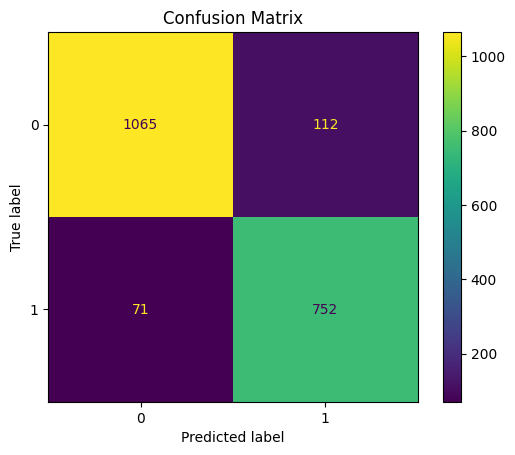

ROC-AUC Score: 0.97


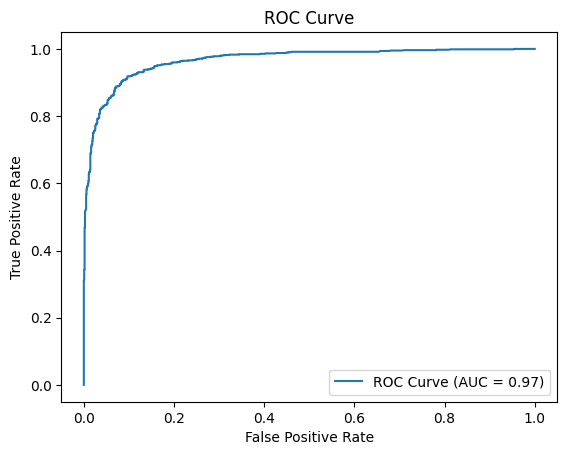

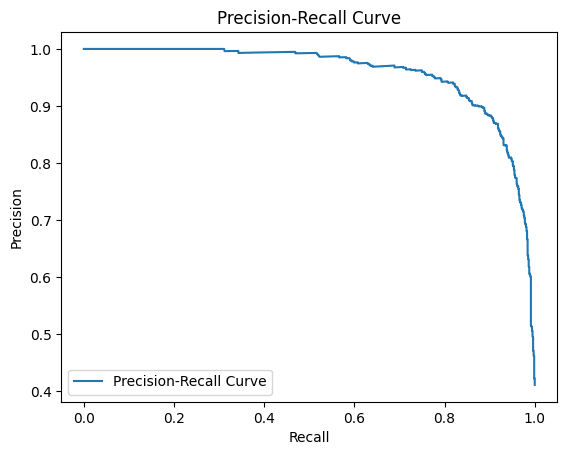

In [85]:
# Step 14: Add additional performance checks

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve
# Import required module
import matplotlib.pyplot as plt

# Convert logits to probabilities using softmax
probs = torch.softmax(torch.tensor(predictions), dim=1).numpy()


# Evaluate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Calculate and display ROC-AUC score
roc_auc = roc_auc_score(true_labels, probs[:, 1])
print(f"ROC-AUC Score: {roc_auc:.2f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(true_labels, probs[:, 1])
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_labels, probs[:, 1])
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
